In [94]:
from numpy import load
import pickle
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn import svm
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_learning_curves
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Implements RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier


# Look into partial fitting. 
# Dataset is not evenly distributed with most being 1.
# Dummy Classifier has 50 % accuracy score... (Only give instances the most frequent label)



# steps_countvec = scipy.sparse.load_npz('recipe_text_features_countvec/train_steps_countvectorizer.pkl')

# Doc2Vect is a technique to transfer words into numerical representation. 
# https://www.shibumi-ai.com/post/a-gentle-introduction-to-doc2vec
d2v_ingr = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/train_ingr_doc2vec100.csv", header=None)
d2v_name = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/train_name_doc2vec100.csv", header=None)
d2v_steps = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/train_steps_doc2vec100.csv", header=None)




# Extract class_labels from training set 
# quick = 1
# medium = 2
# slow = 3
data_train = pd.read_csv('../data/COMP30027_2021_Project2_datasets/recipe_train.csv')

# Obtain the labels
train_label = data_train.iloc[:,-1]




# Feature selection with f_classif (ANOVA F-value)
# ANOVA f-value shows how well a feature discriminate between classes
# The more discrimination, the better that feature is in predicting the class label.
# d2v_name_new = SelectKBest(k=90).fit_transform(d2v_name, train_label)
# d2v_ingr_new = SelectKBest(k=90).fit_transform(d2v_ingr, train_label)
# d2v_steps_new = SelectKBest(k=90).fit_transform(d2v_steps, train_label)
d2v_name_new = pd.DataFrame(d2v_name)
d2v_ingr_new = pd.DataFrame(d2v_ingr)
d2v_steps_new = pd.DataFrame(d2v_steps)
# print(d2v_ingr_new)
# print(d2v_steps_new)
# print(d2v_name_new.shape)


# Create a new dataframe of data, but this time, name, steps and ingr has been engineered to have doc2vec features.
# 100 doc2vec features were given, but we selected 20 best features using ANOVA f-value.
f_data = d2v_name_new.join(data_train.iloc[:,1:3], on=None, how='left', lsuffix='_left', rsuffix='_right')
f_data = f_data.join(d2v_steps_new, on=None, how='left', lsuffix='_left', rsuffix='_right')
f_data = f_data.join(d2v_ingr_new, on=None, how='left', lsuffix='_left', rsuffix='_right')


# # Standardise the data so that the mean is 0
# scaler = StandardScaler()
# f_data = scaler.fit_transform(f_data)

# normalise all values to be between 0 and 1
minmax_scaler = MinMaxScaler()
f_data = minmax_scaler.fit_transform(f_data)
   




# Splitting the provided training into its own train/test
X_train, X_test, y_train, y_test = train_test_split(f_data, train_label, test_size=0.2, stratify=train_label, random_state=42)

# SMOTE sampling
# Synthesise new data by considering k nearest neighbours.
smote = SMOTE(sampling_strategy = 'all', random_state=42, k_neighbors=2)
smX, smY = smote.fit_resample(X_train, y_train)


# Feature selection with chi2
select = SelectKBest(chi2, k=50)
smX = select.fit_transform(smX, smY)
X_test = select.transform(X_test)




smY.value_counts()
smX = pd.DataFrame(smX)
X_test.shape, y_test.shape
smY.value_counts()
f_data.shape

2.0    16197
3.0    16197
1.0    16197
Name: duration_label, dtype: int64

### Random Forest Classifier

Decreases the weight on label 3 to decrease overfitting

In [ ]:

# Rd_Forest_clf = RandomForestClassifier(n_jobs = -1, random_state = 0)




# # Grid search
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }
# CV_rfc = RandomizedSearchCV(estimator=Rd_Forest_clf, param_distributions =param_grid, n_iter=10, cv= 4, random_state=0, n_jobs = -1)
# CV_rfc.fit(X_train, y_train)
# CV_rfc.best_params_



In [159]:
forest = RandomForestClassifier(n_estimators=1000, max_features='log2', max_depth=8, 
                                criterion='entropy', n_jobs = -1, class_weight={1:0.8, 2:0.8, 3:0.4}, random_state = 0)
forest.fit(smX, smY)
Forest_pred = forest.predict(X_test)
Forest_train_pred = forest.predict(smX)
# Check accuracy of Random Forest
print('test:', accuracy_score(y_test, Forest_pred))
print('train:', accuracy_score(smY, Forest_train_pred))
print(classification_report(y_test, Forest_pred))

test: 0.665625
train: 0.680475808277253
              precision    recall  f1-score   support

         1.0       0.66      0.64      0.65      3541
         2.0       0.67      0.73      0.70      4049
         3.0       0.51      0.21      0.30       410

    accuracy                           0.67      8000
   macro avg       0.62      0.53      0.55      8000
weighted avg       0.66      0.67      0.66      8000



In [160]:
test_y = []
train_y = []

for depth in range(1,11):
    forest = RandomForestClassifier(n_estimators=1000, max_features='log2', max_depth=depth, 
                                criterion='entropy', n_jobs = -1, class_weight={1:0.8, 2:0.8, 3:0.5}, random_state = 0)
    
    forest.fit(smX, smY)
    Forest_pred = forest.predict(X_test)
    Forest_train_pred = forest.predict(smX)
    
    test_y.append(accuracy_score(y_test, Forest_pred))
    train_y.append(accuracy_score(smY, Forest_train_pred))
    
    
    


### Learning Curve for RD {Accuracy vs max_depth}
Makes sense, as the DTs become more complex within the forest. The model heads towards overfitting.

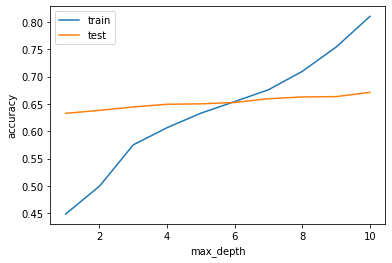

In [128]:
depth = [1,2,3,4,5,6,7,8,9,10]

plt.plot(depth, train_y, label = "train")
plt.plot(depth, test_y, label = "test")
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [45]:
# Dummy Classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='stratified', random_state = 0)
dummy_clf.fit(smX, smY)
dummy_pred = dummy_clf.predict(X_test)
# Check accuracy of Dummy
print(accuracy_score(y_test, dummy_pred))

0.3315


### SVM
The lower the C value in SVM the less penalty is associated with incorrect points and thus lower regularization.

In [60]:
# Grid search
parameters = {'C': np.logspace(-9, 2, 20)}


svc = svm.LinearSVC(dual=False, multi_class='ovr', random_state=0)
gridCV = GridSearchCV(svc, parameters)

gridCV.fit(X_train, y_train)
gridCV.best_params_

{'C': 26.36650898730366}

In [162]:
# # Plot learning curve


# LinearSVC = svm.LinearSVC(dual=False, multi_class='ovr', random_state=0)
# SVC_clf = make_pipeline(MinMaxScaler(), LinearSVC)
SVC_clf = svm.LinearSVC(C=0.00075, dual=False, class_weight={1:0.8, 2:0.8, 3:0.5}, random_state=0)
# plot_learning_curves(smX, smY, X_test, y_test, SVC_clf, scoring= 'accuracy')
# plt.show()
# Implementing LinearSVM from sklearn library
# Similar to SVC with parameter kernel=’linear’, 
# scale better to large numbers of samples.
# supports both dense and sparse input
# multiclass support is handled according to a one-vs-the-rest scheme.
# The more features the better
from sklearn.pipeline import make_pipeline
# LinearSVC = svm.LinearSVC(dual=False, multi_class='ovr', random_state=0)

SVC_clf.fit(smX, smY)

y_test_predict = SVC_clf.predict(X_test)
y_train_predict = SVC_clf.predict(smX)
# np.save('y_predict_name_sparse.npy', y_test_predict)
print("test", accuracy_score(y_test, y_test_predict))
print("train", accuracy_score(smY, y_train_predict))
# print(LinearSVC_clf.score(X_test, y_test))




# 0 score for precision, recall and f1 on class label 3...
print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

test 0.64875
train 0.6508201107200922
              precision    recall  f1-score   support

         1.0       0.67      0.69      0.68      3541
         2.0       0.73      0.62      0.67      4049
         3.0       0.25      0.52      0.34       410

    accuracy                           0.65      8000
   macro avg       0.55      0.61      0.56      8000
weighted avg       0.68      0.65      0.66      8000



array([[2455,  840,  246],
       [1138, 2521,  390],
       [  87,  109,  214]], dtype=int64)

### AdaBoost

In [147]:
Adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,random_state=0), n_estimators=1000, random_state=0)
Adaboost.fit(smX, smY)
Adaboost_pred = Adaboost.predict(X_test)
Adaboost_train_pred = Adaboost.predict(smX)
# Check accuracy of AdaBoost
print(accuracy_score(y_test, Adaboost_pred))
print(accuracy_score(smY, Adaboost_train_pred))
print(classification_report(y_test, Adaboost_pred))

KeyboardInterrupt: 

### Stacking

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/10/how-to-use-stacking-to-choose-the-best-possible-algorithm/

In [146]:
estimators = [
     ('LinearSVC', SVC_clf),
     ('Random Forest', forest),
    ('Adaboost', Adaboost)]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(n_jobs=-1, random_state=0), n_jobs=-1)
stacking_clf.fit(smX, smY)
stacking_y_pred = stacking_clf.predict(X_test)
stacking_y_train_predict = stacking_clf.predict(smX)

print(accuracy_score(y_test, stacking_y_pred))
print(accuracy_score(smY, stacking_y_train_predict))

ValueError: Class label 3 not present.

### Opening and Testing with Real test data

In [108]:
test_ingr = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/test_ingr_doc2vec100.csv", header=None)
test_name = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/test_name_doc2vec100.csv", header=None)
test_steps = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/test_steps_doc2vec100.csv", header=None)

data_test = pd.read_csv('../data/COMP30027_2021_Project2_datasets/recipe_test.csv')


t_data = test_name.join(data_test.iloc[:,1:3], on=None, how='left', lsuffix='_left', rsuffix='_right')
t_data = t_data.join(test_steps, on=None, how='left', lsuffix='_left', rsuffix='_right')
t_data = t_data.join(test_ingr, on=None, how='left', lsuffix='_left', rsuffix='_right')


scaler = MinMaxScaler()
t_data = scaler.fit_transform(t_data)
t_data = select.transform(t_data)
t_data.shape

(10000, 50)

In [111]:
real_pred = stacking_clf.predict(t_data)
real_pred


a = [x for x in range(1,10001)]

result = {
    'id': a,
    'duration_label': real_pred
}
result = pd.DataFrame(result)
result.to_csv('result.csv', index = False)